<a href="https://colab.research.google.com/github/mnmahir/best-fyp/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Libraries**

In [38]:
# Google Drive
from google.colab import drive
# General
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import itertools
# Keras Library
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPool2D
from keras.models import Model
# ScikitLearn
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

print("Keras version: ", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version:  2.4.3
TensorFlow version: 2.3.0


#**Mounting drive and setting path**

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path where dataset is located
dataset_path = '/content/drive/My Drive/FYP Stuff/Datasets/#old/Dataset 1C'
train_path = dataset_path + '/Train'
valid_path = dataset_path + '/Test'    # Some literature use the term "test set" / "valid set" but it is actually a "dev set". This is the set that is iterated during training.
test_path = dataset_path + '/Test'  # Test set helps evaluate how good your final system is. It's ok not to have test set.

#**Variable Initialization**

In [13]:
IMAGE_CLASSES = ['Grade I','Grade II','Grade III', 'Normal']         # Classes (Name must be exactly the same as folder name in each set)
IMAGE_SIZE = [224,224]          # Image size (Set for resizing later)
BATCH_SIZE = 16                 # Mini-batch size
SEED = 1                        # Fixed randomness

# **Initialize Functions**

# Tools

In [ ]:
############################
# Display training and validation curve
############################
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Training', 'Validation'])
############################
# Display confusion matrix
############################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, subplot = 121):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        cm = np.round(cm,2)
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.subplot(subplot)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))  # Count number of classes for x & y axis lable
    plt.xticks(tick_marks, classes, rotation=45) # x-axis label rotated 45 degree
    plt.yticks(tick_marks, classes) # y-axis label
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Augmentation

In [55]:
############################
# Training data generator
############################
def get_train_generator():
  print("Getting train generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 90
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = train_path,
      shuffle = True,             # Shuffle input after each epoch
      target_size = IMAGE_SIZE,   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Validation data generator
############################
def get_valid_generator():
  print("Getting valid generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = IMAGE_SIZE,   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

def get_test_generator():
  print("Getting test generator...")
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255
  )

  generator = image_generator.flow_from_directory(
      batch_size = BATCH_SIZE,
      directory = valid_path,
      shuffle = False,             # Shuffle input after each epoch
      target_size = IMAGE_SIZE,   # Set image size to be [x]px by [y]px set in IMAGE_SIZE
      class_mode = 'categorical',
      seed = SEED,
  )

  return generator
############################
# Show generated image
############################
def show_image_generated(generator, index, img_size):
  x, y = valid_generator.__getitem__(index)
  img_plt = math.ceil(math.sqrt(BATCH_SIZE))
  grid_plt = str(img_plt)+str(img_plt)+str(1)
  plt.figure(1, figsize = (img_size,img_size))
  for i in range(BATCH_SIZE):
    plt.subplot(img_plt,img_plt,i+1)
    plt.imshow(x[i])
    plt.title(IMAGE_CLASSES[np.where(y[i] == 1.)[0][0]], fontsize = 2+img_size, pad = 0)
    plt.axis('off')
  plt.show()
############################
# Solving class imbalance
############################
def get_freq_data(generator):
  class_data_labels = generator.classes
  total_class = len(IMAGE_CLASSES)
  freq_out = []

  for i in range(total_class):
    total_label_i = 0
    for ele in class_data_labels:
      if ele == i:
        total_label_i += 1
    freq_out.append(total_label_i)
  
  print("Total number of class is:", total_class, IMAGE_CLASSES)
  print("Total image in generator is: ", freq_out)

# Model Development

In [56]:
def get_pretrained_model(transfer_learning_model = 'VGG16', print_summary = False):
  #################Choose Pre-trained model##########################
  if transfer_learning_model == 'Xception':
    print("Xception pre-trained model selected")
    pretrained_model = tf.keras.applications.Xception(input_shape = [*IMAGE_SIZE, 3], weights = 'imagenet', include_top=False)
  elif transfer_learning_model == 'VGG16':
    print("VGG16 pre-trained model selected")
    pretrained_model = tf.keras.applications.VGG16(input_shape = [*IMAGE_SIZE, 3], weights = 'imagenet', include_top=False)
  else:
    print("Not defined / Does not exist")
    return 0
  ##################################################################
  # Freeze early layers
  for layer in pretrained_model.layers:
    layer.trainable = False

  # Fine tuning our layers - you can add more if you want
  x = Flatten()(pretrained_model.output)
  x = Dropout(0.8)(x)
  x = Dense(1024, activation = 'relu')(x)

  # Prediction layer
  prediction = Dense(len(IMAGE_CLASSES), activation='softmax')(x)

  # Create a model object
  model = Model(inputs=pretrained_model.input, outputs=prediction)

  # Compile model
  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  if print_summary:
    model.summary()

  return model


# **Training**

In [57]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()
test_generator = get_test_generator()

Getting train generator...
Found 2708 images belonging to 4 classes.
Getting valid generator...
Found 676 images belonging to 4 classes.
Getting test generator...
Found 676 images belonging to 4 classes.


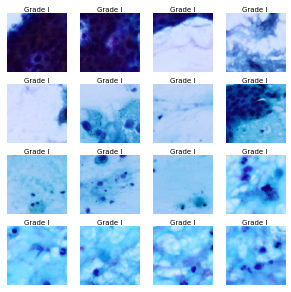

Total number of class is: 4 ['Grade I', 'Grade II', 'Grade III', 'Normal']
Total image in generator is:  [581, 1035, 648, 444]


In [46]:
# Check image generated by generator
#gen_image = train_generator
#show_image_generated(gen_image, index = 0, img_size = 5)  # Print image generated by generator. Change index to see different batch (start at 0)
#get_freq_data(gen_image)

In [44]:
model = get_pretrained_model('Xception', print_summary = False)

Xception pre-trained model selected


In [45]:
EPOCH = 50                      # Number of training epoch
history = model.fit(
  train_generator,
  epochs=EPOCH,
  validation_data=valid_generator,
  steps_per_epoch=valid_generator.samples / valid_generator.batch_size ,
  validation_steps=valid_generator.samples / valid_generator.batch_size,
  verbose=1
)

Epoch 1/50
43/42 [==============================] - 12s 287ms/step - loss: 4.1972 - accuracy: 0.5596 - val_loss: 1.2953 - val_accuracy: 0.6612
Epoch 2/50
43/42 [==============================] - 12s 268ms/step - loss: 1.1420 - accuracy: 0.6308 - val_loss: 0.9247 - val_accuracy: 0.6612
Epoch 3/50
43/42 [==============================] - 12s 272ms/step - loss: 0.8944 - accuracy: 0.6570 - val_loss: 1.0144 - val_accuracy: 0.6139
Epoch 4/50
43/42 [==============================] - 11s 267ms/step - loss: 0.9323 - accuracy: 0.6805 - val_loss: 0.8277 - val_accuracy: 0.7056
Epoch 5/50
43/42 [==============================] - 12s 272ms/step - loss: 0.7605 - accuracy: 0.7151 - val_loss: 0.7277 - val_accuracy: 0.7367
Epoch 6/50
43/42 [==============================] - 11s 266ms/step - loss: 0.8284 - accuracy: 0.7071 - val_loss: 0.7749 - val_accuracy: 0.7470
Epoch 7/50
43/42 [==============================] - 11s 266ms/step - loss: 0.7182 - accuracy: 0.7263 - val_loss: 0.8017 - val_accuracy: 0.7130

# **Save & Reload Model**

In [47]:
SAVE_MODEL_NAME = 'VGG16.h5'         # Name of the model
model.save(SAVE_MODEL_NAME) #Save
reloaded_model = tf.keras.models.load_model(SAVE_MODEL_NAME) #Load

# **Evaluation**

**Loss and Accuracy**

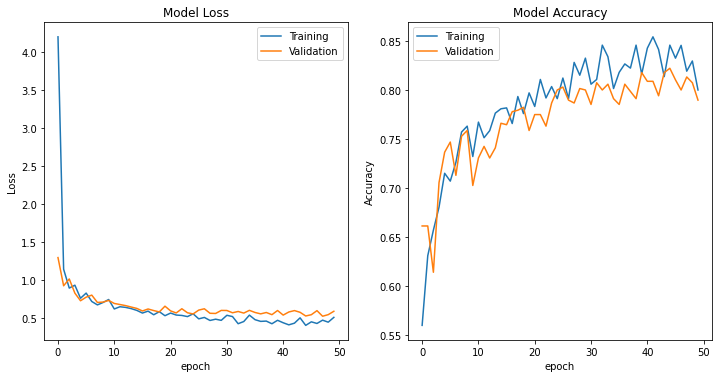

In [49]:
plt.subplots(figsize=(10,5))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 122)

**Confusion Matrix**

In [60]:
# True label
true_labels = test_generator.classes  # Get label of valid_generator
# Prediction label
predictions = reloaded_model.predict(x=test_generator, steps=len(test_generator),verbose = 0)
pred_labels = np.argmax(predictions, axis=-1)

Confusion matrix, without normalization
[[117  19   7   2]
 [ 10 230  14   4]
 [  6  53  98   5]
 [  4  18   0  89]]
Normalized confusion matrix
[[0.81 0.13 0.05 0.01]
 [0.04 0.89 0.05 0.02]
 [0.04 0.33 0.6  0.03]
 [0.04 0.16 0.   0.8 ]]


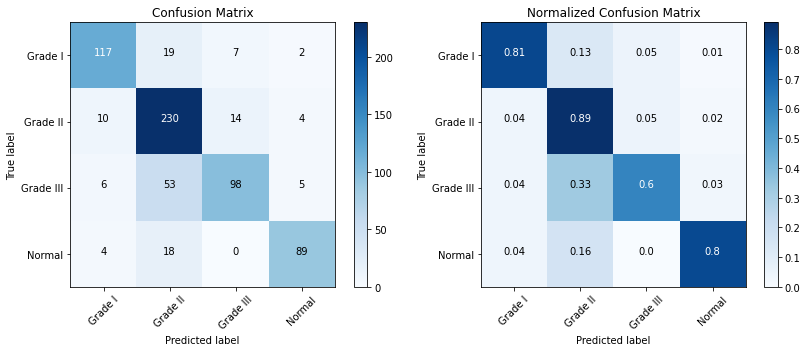

In [61]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
plt.subplots(figsize=(12,5))
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Confusion Matrix',normalize=False, subplot=121)
plot_confusion_matrix(cm=cm, classes=IMAGE_CLASSES, title='Normalized Confusion Matrix',normalize=True, subplot=122)

**Other Metrics**

In [62]:
report = metrics.classification_report(y_true = true_labels, y_pred = pred_labels, target_names=IMAGE_CLASSES)
print(report)

              precision    recall  f1-score   support

     Grade I       0.85      0.81      0.83       145
    Grade II       0.72      0.89      0.80       258
   Grade III       0.82      0.60      0.70       162
      Normal       0.89      0.80      0.84       111

    accuracy                           0.79       676
   macro avg       0.82      0.78      0.79       676
weighted avg       0.80      0.79      0.79       676

